In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image
from datetime import date

from tqdm import tqdm
import os 

import xarray as xr

In [2]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]
N_year = len(Years)

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [3]:
Lats_edge = np.arange(-90,91,6)
Lons_edge = np.arange(-180,181,10)

Lats_mid = np.arange(-87,90,6)
Lons_mid = np.arange(-175,180,10)
Levs = [350, 300, 250, 225, 200, 175, 150, 125, 100, 70, 50, 30, 20, 10]
# Levs = [300, 250, 225, 200, 175, 150, 125, 100, 70, 50, 30, 20, 10]
# [100, 85, 75, 65, 55, 40, 30, 20, 10] 
# [100, 70, 50, 30, 20, 10]

# Heights = [16, 18, 19, 20, 22, 24]
# [100, 75, 65, 55, 40, 30]


N_lat = len(Lats_mid)
N_lon = len(Lons_mid)
N_lev = len(Levs) # 16, 18, 19, 20, 22, 24 km

# N_lev, Lats_edge, Lons_edge, Lats_mid, Lons_mid, N_lat, N_lon, Lons_edge[-1]

In [4]:
# calculate the area of lon-lat grid [km^2]
def Area_Lat_Weghted(lat1, lat2, d_lon):
    # A = π R² (sin φ1 − sin φ2) (θ1 − θ2)/180.
    Re = 6378 # km
    Area = math.pi * Re**2 * abs(np.sin(np.deg2rad(lat1))-np.sin(np.deg2rad(lat2))) * d_lon/180
    return Area

def Length_Lat_line(lat):
    Re = 6378 # km
    Length = 2 * math.pi * ( Re * np.cos(np.deg2rad(lat)) )
    return abs(Length)

In [5]:
Grid_area = np.zeros((N_lat, N_lon))

for iy in range(N_lat):
    Grid_area[iy,:] = Area_Lat_Weghted( Lats_edge[iy], Lats_edge[iy+1], abs(Lons_mid[1]-Lons_mid[0]) )

In [6]:
# Grid_area[:,0]

In [7]:
ds = xr.open_dataset('/n/home12/hongwei/HONGWEI/ERA5_pressue/ERA5_z_tmean_coarse3.nc')
ds


<xarray.Dataset> Size: 389kB
Dimensions:    (time: 1, bnds: 2, longitude: 36, latitude: 30, level: 18)
Coordinates:
  * time       (time) datetime64[ns] 8B 2007-06-16
  * longitude  (longitude) float32 144B -175.0 -165.0 -155.0 ... 165.0 175.0
  * latitude   (latitude) float32 120B -87.0 -81.0 -75.0 ... 75.0 81.0 87.0
  * level      (level) int32 72B 1 2 3 5 7 10 20 ... 125 150 175 200 225 250 300
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 16B ...
    z          (time, level, latitude, longitude) float32 78kB ...
    t          (time, level, latitude, longitude) float32 78kB ...
    u          (time, level, latitude, longitude) float32 78kB ...
    v          (time, level, latitude, longitude) float32 78kB ...
    w          (time, level, latitude, longitude) float32 78kB ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Feb 19 21:10:19 2024: cdo remapbil,gridfile3.txt ERA5_z...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

In [8]:
Grid_z = ds['z'][0,5::,:,:]/9.8/1e3 # km
Grid_dz = Grid_z*0.0
Grid_V = Grid_dz*0.0

for iz in range(len(Grid_dz[:,0,0])):
    if iz==0:
        Grid_dz[iz,:,:] = Grid_z[iz]-Grid_z[iz+1]
    elif iz==len(Grid_dz[:,0,0])-1:
        Grid_dz[iz,:,:] = Grid_z[iz-1]-Grid_z[iz]
    else:
        Grid_dz[iz,:,:] = (Grid_z[iz-1]-Grid_z[iz+1])/2
    
    Grid_V[iz,:,:] = Grid_dz[iz,:,:]*Grid_area[:,:] 
    
# reverser the vertical grid!!!
Grid_V_Xmean = np.mean(Grid_V[::-1,:,:], axis=2)
Grid_V.shape # [km^3]

(13, 30, 36)

In [9]:
# count the particle (injected at different height) number in each grid cell
N_day = 20*366
Num_2D = np.zeros((N_lat, N_lon, N_lev, N_day)) 


for i_year in tqdm(range(N_year)):
    # File = open('/n/home12/hongwei/Paper_2/Plot_python/Num_Concnt/Num_Concnt_2000_'+Years[i_year]+'.txt', 'r')
        
    # total
    File = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number_Within_15deg_Vertical_Levels/Num_Concnt_data/Num_Concnt_2000_'+Years[i_year]+'.txt', 'r')

    # lower stratosphere: below 50hPa
#     File = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number/Num_Concnt_data/Num_Concnt_lower_2000_'+Years[i_year]+'.txt', 'r')

    # higher stratosphere: below 50hPa
#     File = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number/Num_Concnt_data/Num_Concnt_upper_2000_'+Years[i_year]+'.txt', 'r')
    
    
    Lines = File.readlines()
    

    NUMs = np.zeros((N_lon*N_lat*N_day, N_lev))
    
    ii = 0
    for line in Lines:
        a = line.split(',')
        for iz in range(N_lev):
            NUMs[ii,iz] = float(a[iz+3])
        ii = ii+1

    Num_2D_temp = np.zeros((N_lat, N_lon, N_lev, N_day)) 
    for i_day in range(N_day):
        for ix in range(N_lon):
            for iy in range(N_lat):
                ii = i_day*(N_lat*N_lon) + ix*N_lat + iy
                Num_2D_temp[iy, ix, :, i_day] = NUMs[ii,:]
               
            
    Num_2D = Num_2D + Num_2D_temp
    
print(ii)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:58<00:00, 41.81s/it]

7905599


In [10]:
print("LAT Before: ", Lats_mid)

if Lats_mid[0]<Lats_mid[-1]:
    Lats_edge = Lats_edge[::-1]
    Lats_mid = Lats_mid[::-1]
    Num_2D[:, :, :, :] = Num_2D[::-1, :, :, :]

print("LAT After: ", Lats_mid)

LAT Before:  [-87 -81 -75 -69 -63 -57 -51 -45 -39 -33 -27 -21 -15  -9  -3   3   9  15
  21  27  33  39  45  51  57  63  69  75  81  87]
LAT After:  [ 87  81  75  69  63  57  51  45  39  33  27  21  15   9   3  -3  -9 -15
 -21 -27 -33 -39 -45 -51 -57 -63 -69 -75 -81 -87]


In [11]:
# monthly data
# To simplify, assume all months have 30 days

N_month = 20*12

Num_2D_month = np.zeros((N_lat, N_lon, N_lev, N_month))

for i_mon in range(N_month):
    Num_2D_month[:,:,:,i_mon] = np.mean(Num_2D[:,:,:,i_mon*30:(i_mon+1)*30], axis=3)

(7320,)


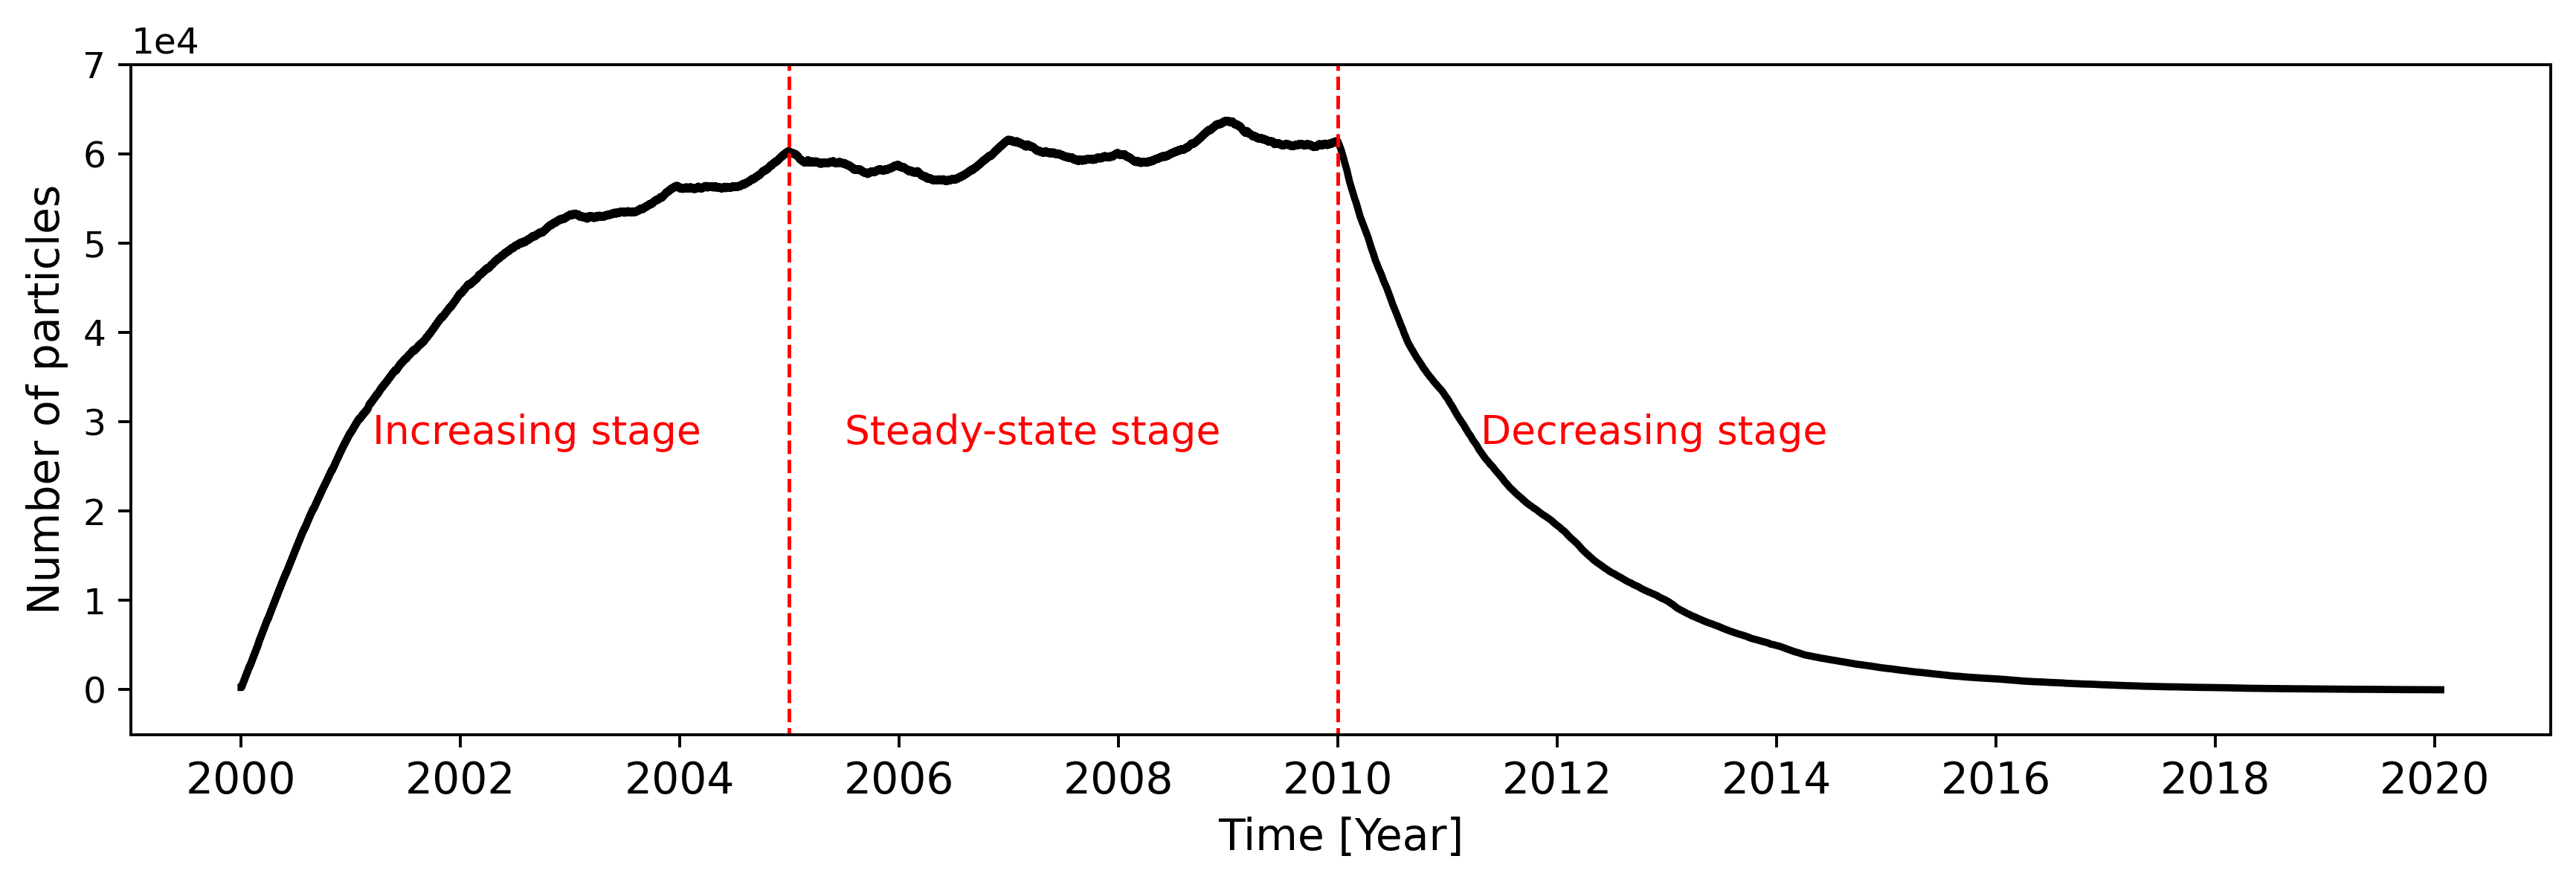

In [15]:
#
# plot the time series of the total particle number

total_num = np.sum( Num_2D, axis=(0,1,2) )
print(total_num.shape)
Ndays = total_num.shape[0]

# plot---------------------------------------------------
fig = plt.figure(figsize=(10,3.5), dpi=350)

iday_begin = 0
iday_end = Ndays

Days = np.arange(iday_begin, iday_end, 1)

plt.plot(Days, total_num[iday_begin:iday_end], 'k-', linewidth=2)

plt.plot([365*5-1,365*5-1], [-1e4,1.2e5], 'r--', linewidth=1)
plt.plot([365*10-1,365*10-1], [-1e4,1.2e5], 'r--', linewidth=1)

plt.text(365*1.2,  2.75e4, 'Increasing stage', fontsize = 11, color='red')
plt.text(365*5.5,  2.75e4, 'Steady-state stage', fontsize = 11, color='red')
plt.text(365*11.3, 2.75e4, 'Decreasing stage', fontsize = 11, color='red')

# plt.plot(Days, Days*21*24/3, label=f"{Levs[iz]} hPa")

plt.ylim(-0.5e4,7.0e4)
# plt.ylim(-1.0e4,1.8e5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=12)

# plt.xscale("log")
# plt.yscale("log")

# Set text labels and properties.
plt.xticks(np.arange(0,20*365+1,2*365), 
       ['2000', '2002', '2004', '2006', '2008', '2010', \
        '2012', '2014', '2016', '2018', '2020'], rotation=0, fontsize=12)  

plt.xlabel("Time [Year]", fontsize=12)
plt.ylabel("Number of particles", fontsize=12);
# plt.legend();
plt.tight_layout()
plt.savefig("Figure_1.jpg")

# Global distribution of particle numbers: alt vs. lat

In [ ]:
# Lats_mid = np.arange(-87,90,6)
# Lons_mid = np.arange(-175,180,10)
# Levs = [100, 75, 65, 55, 40, 30]
# Num_2D = np.zeros((N_lat, N_lon, N_lev, N_day))
Levs = np.array(Levs)
Lats_mid.shape, Levs.shape, Num_2D[:,0,:,0].shape

In [ ]:
# Num_2D_Xmean_5yr.shape, Grid_V_Xmean.shape

In [ ]:
Length_lat = Grid_V_Xmean[:,:]*0.0
for iy in range(N_lat):
    Length_lat[:,iy] = Length_Lat_line(Lats_mid[iy])

fig = plt.figure(figsize=(5,4), dpi=350)

# levs = np.arange(0,40,2)
Num_2D_Xmean_5yr = np.mean(Num_2D[:,:,:,365*5:365*10], axis=(1,3))
plt.contourf(Lats_mid, Levs[1:14], np.transpose(Num_2D_Xmean_5yr[:,1:14])/Grid_V_Xmean[:,:]* Length_lat[:,:]*1e6, levels=20, cmap="Reds", extend='max')

# plt.colorbar(label=f'[#/m$^{2}$]', location='bottom');
cbar = plt.colorbar(aspect=50, label=f'Number Concentration [#/m$^{2}$]', location='bottom');
cbar.formatter.set_powerlimits((0, 0))

plt.scatter(np.arange(-15,16,3), np.arange(-15,16,3)*0.0+65, np.arange(-15,16,3)*0.0+2, 'yellow')

# plt.xtick([-90,-60,-30,0,30,60,90])

plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel('Latitude')
plt.ylabel('Pressure [hPa]')
plt.title('(a)');

plt.tight_layout() 

plt.savefig("Figure_4a.jpg")

In [ ]:

fig = plt.figure(figsize=(5,4), dpi=350)

levs = np.arange(0,40,2)
Num_2D_Xmean_5yr = np.mean(Num_2D[:,:,:,365*5:365*10], axis=(1,3))
plt.contourf(Lats_mid, Levs[1:14], np.transpose(Num_2D_Xmean_5yr[:,1:14]), levels=levs, cmap="Reds", extend='max')
plt.colorbar(label='Particle number', location='bottom');

plt.scatter(np.arange(-15,16,3), np.arange(-15,16,3)*0.0+65, np.arange(-15,16,3)*0.0+2, 'k')

plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel('Latitude')
plt.ylabel('Pressure [hPa]')
plt.title('(a)');

plt.savefig("Figure_4a.jpg")

# Global distribution of particle number between QBO east vs. west phase

In [17]:
Num_2D_Xmean = np.mean(Num_2D, axis=1)

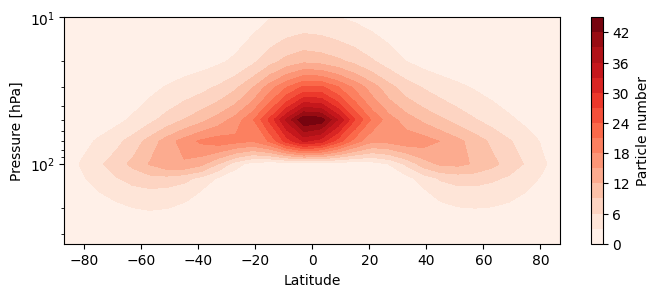

In [19]:
time_lag = 3*30

it_w1 = 365*5+time_lag
it_w2 = 365*5+4*30+time_lag

it_w3 = 365*7+time_lag
it_w4 = 365*7+4*30+time_lag

it_w5 = 365*9+time_lag
it_w6 = 365*9+4*30+time_lag


N_day_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1

fig = plt.figure(figsize=(8,3), dpi=100)

Num_2D_Xmean_5yr_west = \
(np.sum(Num_2D_Xmean[:,:,it_w1:it_w2], axis=2) + np.sum(Num_2D_Xmean[:,:,it_w3:it_w4], axis=2) + np.sum(Num_2D_Xmean[:,:,it_w5:it_w6], axis=2)) / N_day_W

plt.contourf(Lats_mid, Levs, np.transpose(Num_2D_Xmean_5yr), levels=14, cmap="Reds")

plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel('Latitude')
plt.ylabel('Pressure [hPa]')

plt.colorbar(label='Particle number');

In [20]:
it_e1 = 365*6+time_lag
it_e2 = 365*6+4*30+time_lag

it_e3 = 365*8+time_lag
it_e4 = 365*8+4*30+time_lag


N_day_E = it_e4-it_e3 + it_e2-it_e1

fig = plt.figure(figsize=(6,3), dpi=350)

Num_2D_Xmean_5yr_east = \
( np.sum(Num_2D_Xmean[:,:,it_e1:it_e2], axis=2) + np.sum(Num_2D_Xmean[:,:,it_e3:it_e4], axis=2) ) / N_day_E

plt.contourf(Lats_mid, Levs, np.transpose(Num_2D_Xmean_5yr), levels=14, cmap="Reds")

plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel('Latitude')
plt.ylabel('Pressure [hPa]')
plt.title('Particle number density')

# plt.colorbar(label=f'[#/km$^{2}$]');

NameError: name 'time_lag' is not defined

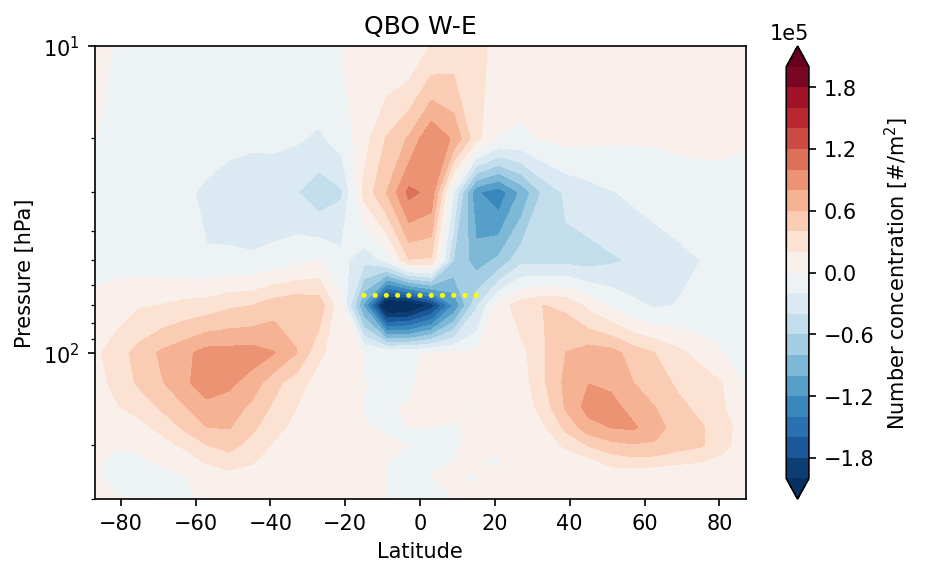

In [28]:
fig = plt.figure(figsize=(7,4), dpi=150)

Num_2D_Xmean_5yr_diff = Num_2D_Xmean_5yr_west - Num_2D_Xmean_5yr_east

levs=np.linspace(-2e5,2e5,21)
plt.contourf(Lats_mid, Levs[1:14], np.transpose(Num_2D_Xmean_5yr_diff[:,1:14])/Grid_V_Xmean[:,:]* Length_lat[:,:]*1e6, \
             levels=levs, cmap="RdBu_r", extend='both')

# plt.colorbar(label='Particle number diffenrece');
cbar = plt.colorbar(label=f'Number concentration [#/m$^{2}$]');
cbar.formatter.set_powerlimits((0, 0))

plt.scatter(np.arange(-15,16,3), np.arange(-15,16,3)*0.0+65, np.arange(-15,16,3)*0.0+2, 'yellow')

plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel('Latitude')
plt.ylabel('Pressure [hPa]')
plt.title('QBO W-E');

